# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [32]:
%pip install seaborn
%pip install plotly
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [33]:
data = pd.read_csv('data/vehicles.csv')

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### 1, Check the dimention of the data

In [34]:
data.shape

(426880, 18)

In [35]:
data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [36]:
data.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


### 2, Check the null value

In [37]:
data.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

<Axes: >

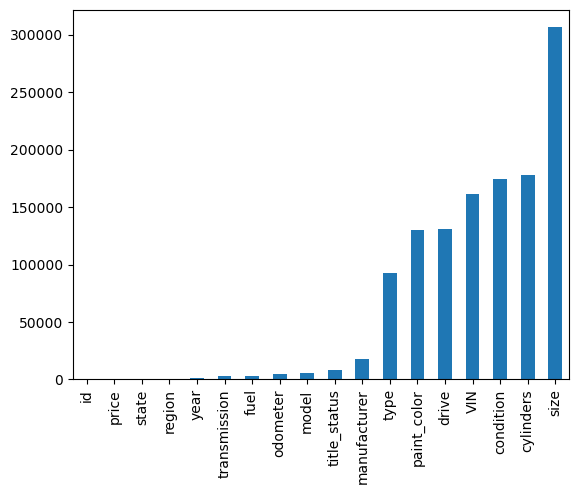

In [38]:
data.isnull().sum().sort_values().plot(kind  = 'bar')

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

### 2, Drop columns with too many nulls

In [39]:
missing_pct = data.isna().mean()
high_null_cols = missing_pct[missing_pct > 0.50].index.tolist() # remove rows with missing value > 50% 
id_like_cols = [c for c in ["VIN", "id", "url"] if c in data.columns]
cols_to_drop = sorted(list(set(high_null_cols + id_like_cols)))
data = data.drop(columns=cols_to_drop, errors="ignore")
data.shape[0]

426880

### 3, Standardize text(lowercase)

In [40]:
obj_cols = data.select_dtypes(include=["object"]).columns
for c in obj_cols:
    data[c] = data[c].astype(str).str.strip().str.lower().replace({"nan": np.nan})

### 4, Remove duplicates

In [41]:
data = data.drop_duplicates()
data.shape[0]

370382

### 5, Drop the rows when important value missing

In [56]:
important_fields = [c for c in ["price", "year", "odometer","fuel"] if c in data.columns]
#If any of the critical_fields columns has a missing value in a row → that row gets deleted.
if important_fields:
    data = data.dropna(subset=important_fields)
data = data[data['price'] != 0]
data = data[data['price'] < 500000]
data.shape[0]

339657

### 6, Add unknown when some categorical columns missing 

In [13]:
'''
cat_cols = data.select_dtypes(exclude=[np.number]).columns

for c in cat_cols:
    if data[c].isna().any():
        data[c] = data[c].fillna("unknown")
'''

In [57]:
data["title_status"].nunique()

6

In [58]:
data["title_status"].unique()

array(['clean', 'rebuilt', 'lien', nan, 'salvage', 'missing',
       'parts only'], dtype=object)

In [59]:
data["manufacturer"].unique()

array(['gmc', 'chevrolet', 'toyota', 'ford', 'jeep', 'nissan', 'ram',
       'mazda', 'cadillac', 'honda', 'dodge', 'lexus', 'jaguar', 'buick',
       'chrysler', 'volvo', 'audi', 'infiniti', 'lincoln', 'alfa-romeo',
       'subaru', nan, 'acura', 'hyundai', 'mercedes-benz', 'bmw',
       'mitsubishi', 'volkswagen', 'porsche', 'kia', 'rover', 'ferrari',
       'mini', 'pontiac', 'fiat', 'tesla', 'saturn', 'mercury',
       'harley-davidson', 'datsun', 'aston-martin', 'land rover',
       'morgan'], dtype=object)

In [ ]:
### 7, Normalization

In [60]:
X=data[['year','odometer','fuel']]
X_norm = X.copy()
X_norm[['year']] = (X[['year']]-X[['year']].mean())/X[['year']].std()
X_norm[['odometer']] = (X[['odometer']]-X[['odometer']].mean())/X[['odometer']].std()
y=data['price']
#y.shape
#X_norm.shape

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

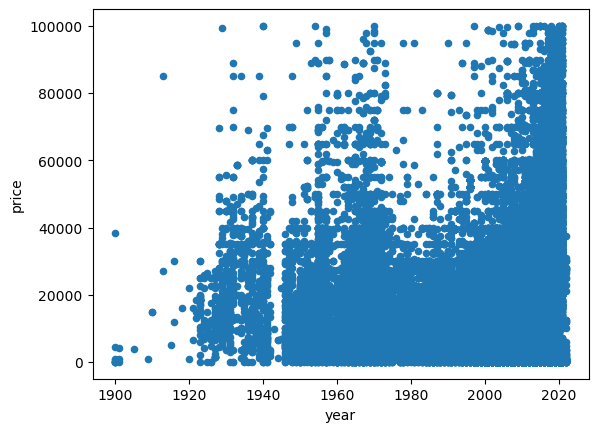

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=22)
df=pd.DataFrame(data)
df.plot.scatter(x='year', y='price')
plt.show()

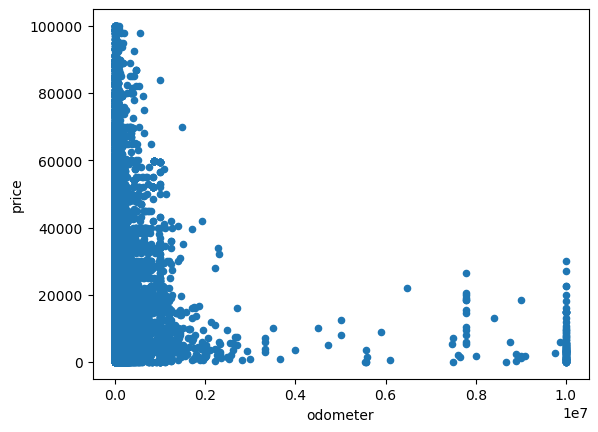

In [62]:
df.plot.scatter(x='odometer', y='price')
plt.show()

In [63]:
lr_fuel = LinearRegression(fit_intercept=True).fit(pd.get_dummies(X_train[['fuel']]),y_train)
loss_fuel_train = mean_squared_error(lr_fuel.predict(pd.get_dummies(X_train[['fuel']])),y_train)
loss_fuel_test = mean_squared_error(lr_fuel.predict(pd.get_dummies(X_test[['fuel']])),y_test)
print(loss_fuel_train/loss_fuel_test)

0.9921228854815767


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [64]:
lr_com = LinearRegression(fit_intercept=True).fit(pd.get_dummies(X_train[['year','odometer','fuel']]),y_train)
loss_com_train = mean_squared_error(lr_com.predict(pd.get_dummies(X_train[['year','odometer','fuel']])),y_train)
loss_com_test = mean_squared_error(lr_com.predict(pd.get_dummies(X_test[['year','odometer','fuel']])),y_test)
print(loss_com_train/loss_com_test)

0.9945213229673777


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
model_predictions = {f'degree_{i}': None for i in range(1, 3)}
for i in range(1, 3):
    pipe = Pipeline([('features', PolynomialFeatures(degree = i, include_bias = False)), ('model', LinearRegression())])
    pipe.fit(pd.get_dummies(X_train[['year','odometer','fuel']]),y_train)
    preds = pipe.predict(pd.get_dummies(X_train[['year','odometer','fuel']]))
    model_predictions[f'degree_{i}'] = preds
model_predictions['degree_1'][:10]

array([203581.98251473, 119763.34855747,  67361.29652773,  34448.29997037,
       138242.89508155, 178064.00006039,  71497.43080888,  24541.22092122,
        65877.15034868, -53705.15031595])

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [ ]:
#I analyzed the dataset to identify that the features, including odometer, year, and fuel type, 
#most strongly influence the target variable, car price. 